# Análise estatística ilustrando o uso do sistema Bike Sampa

## Este caderno responde às seguintes questões:

### - Quantas viagens ocorreram através dos anos?
### - Qual é a distância média percorrida pelos usuários?
### - Quanto tempo duram as viagens?
### - Qual é a idade média dos usuários?
### - Qual é a velocidade média de homens e mulheres?

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.dates as mdate
import geopandas as gpd
import folium
import math
import datetime as dt
import glob
from ipywidgets import interact_manual, widgets
from scipy.interpolate import CubicSpline
import seaborn as sbn
import warnings

import bikescience.charts as ch
import tembici.load_trips as load
import ecobici.stations as est
import bikescience.distributions as dist
from IPython.core.display import display, HTML

pd.set_option('display.float_format', lambda x: '%.1f' % x)
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18
warnings.simplefilter('ignore')

## Carregando todas as viagens do Ecobici de Março de 2019 a Abril de 2019

In [2]:
trips = load.load_trips_files('../../ecobici/trips_*.csv')
display(HTML('<div class=\"custom\"><h3>%s viagens</h3>'%(len(trips))))

In [3]:
stations = est.stations_geodf('../../ecobici/ecobici-buenos-aires.json')
display(HTML('<div class=\"custom\"><h3>%s estações em Buenos Aires</h3>'%(len(stations))))

## Idade

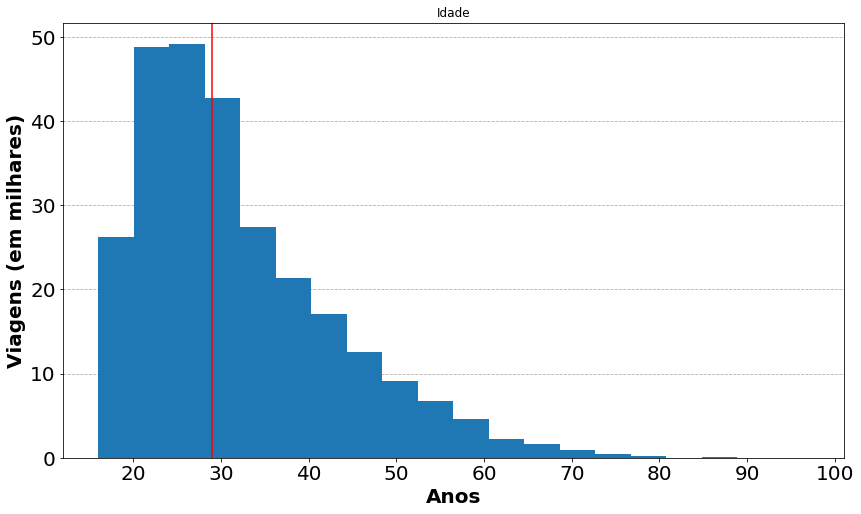

In [4]:
tage = trips[~trips["birth year"].isnull()]
tage = tage["starttime"].dt.year - tage["birth year"]
tage = tage[(tage > 0) & (tage < 100)]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=10)
ax_age = plt.axes()
ax_age.set_axisbelow(True)
plt.grid(linestyle='--')
ax_age.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_age.yaxis.set_major_formatter(formatter)
ax_age.xaxis.set_major_locator(loc)
plt.hist(bins=20,x=tage)
plt.axvline(x=tage.median(),color='red')
plt.title('Idade')
plt.xlabel('Anos')
plt.ylabel('Viagens (em milhares)')
plt.show()

##   Duração das viagens

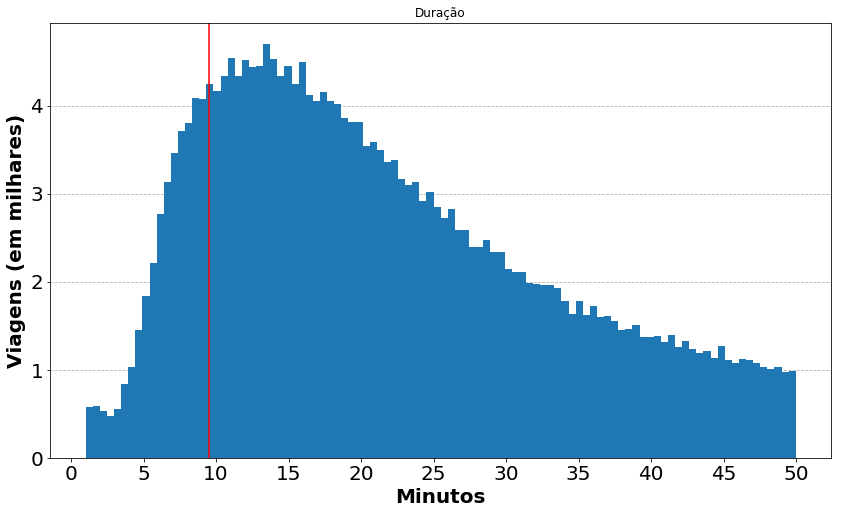

In [5]:
duration = trips[trips['tripduration'] < 3000]
duration = duration[['tripduration']]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=5)

ax_duration = plt.axes()
ax_duration.set_axisbelow(True)
plt.grid(linestyle='--')
ax_duration.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_duration.yaxis.set_major_formatter(formatter)
ax_duration.xaxis.set_major_locator(loc)
plt.hist(bins=100,x=duration['tripduration']/60)
plt.title('Duração')
plt.xlabel('Minutos')
plt.ylabel('Viagens (em milhares)')
#fig_duration = plt.gcf()
plt.axvline(x=9.5,color='red')
plt.show()

## Gênero

In [6]:
male = trips[trips['gender'] == 'Masc']
female = trips[trips['gender'] == 'Fem']
unknown = trips[trips['gender'] == 'Null']
display(HTML('<div class=\"custom\"><h3>Homens: %s (%s)</h3>'%("{0:.2%}".format(len(male) / len(trips)),len(male))))
display(HTML('<div class=\"custom\"><h3>Mulheres: %s (%s)</h3>'%("{0:.2%}".format(len(female) / len(trips)),len(female))))
display(HTML('<div class=\"custom\"><h3>Desconhecido: %s (%s)</h3>'%("{0:.2%}".format(len(unknown) / len(trips)),len(unknown))))

## Distância

Usando o algoritmo GraphHoper

In [7]:
stations_distances = pd.read_csv('../../ecobici/stations_distances.csv')
merge = trips.merge(stations_distances, on=['start_station_name', 'end_station_name'])
merge['speed'] = merge['distance']/merge['tripduration']*3600

### Distância (ignorando viagens circulares)

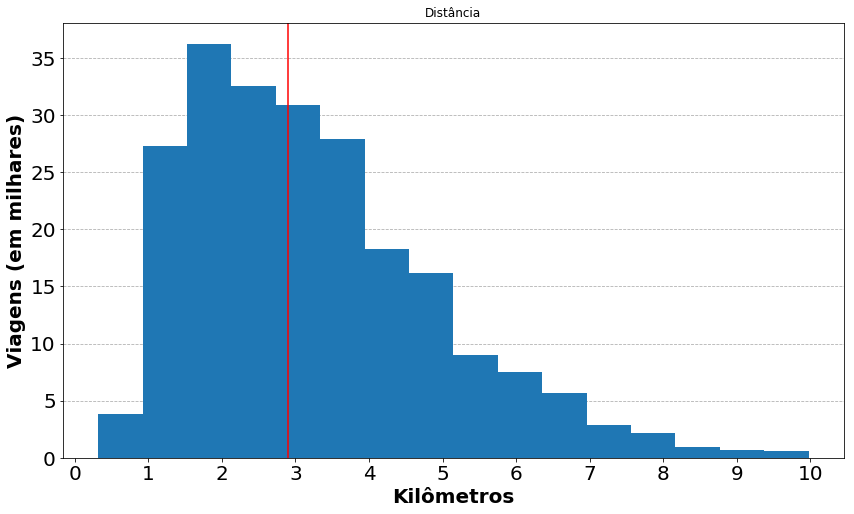

In [8]:
distance = merge[(merge.distance<10) & (merge.distance>0)]

distance = distance[['distance']]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=1)

ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_distance.yaxis.set_major_formatter(formatter)
ax_distance.xaxis.set_major_locator(loc)
plt.hist(bins=16,x=distance['distance'])
plt.title('Distância')
plt.xlabel('Kilômetros')
plt.ylabel('Viagens (em milhares)')
plt.axvline(x=distance['distance'].median(),color='red')
#fig_distance = plt.gcf()
plt.show()

In [9]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#distance['distance'].describe()

## Velocidade: Mulheres são um pouco menos apressadas :-)


In [10]:
gender = merge
gender = gender[gender.distance < 50]
gender.reset_index(inplace=True)
gender = gender[['gender','distance','tripduration','speed']]


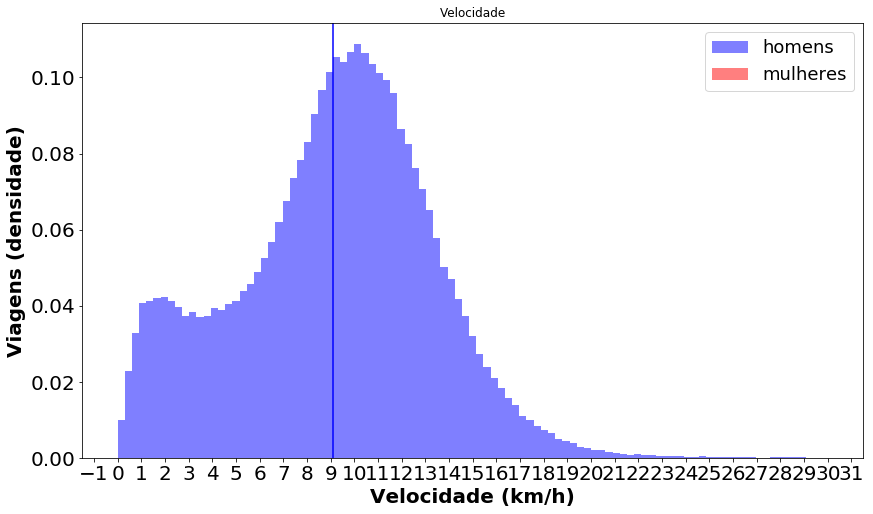

In [11]:
women_speed = gender[(gender.gender == 'Fem') & (gender.speed> 0) & (gender.speed < 30)].speed
men_speed   = gender[(gender.gender == 'Masc') & (gender.speed> 0) & (gender.speed < 30)].speed

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=1)

bins = np.linspace(0, 30, 100)
ax_gender = plt.axes()
ax_gender.xaxis.grid(False)
ax_gender.yaxis.grid(False)
ax_gender.xaxis.set_major_locator(loc)
plt.hist(men_speed, bins, alpha=0.5, label='homens', density=True, color='blue')
plt.hist(women_speed, bins, alpha=0.5, label='mulheres', density=True, color='red')
plt.legend(loc='upper right')
plt.title('Velocidade')
plt.axvline(x=women_speed.mean(),color='red')
plt.axvline(x=men_speed.mean(),color='blue')
plt.xlabel('Velocidade (km/h)')
plt.ylabel('Viagens (densidade)')
plt.show()

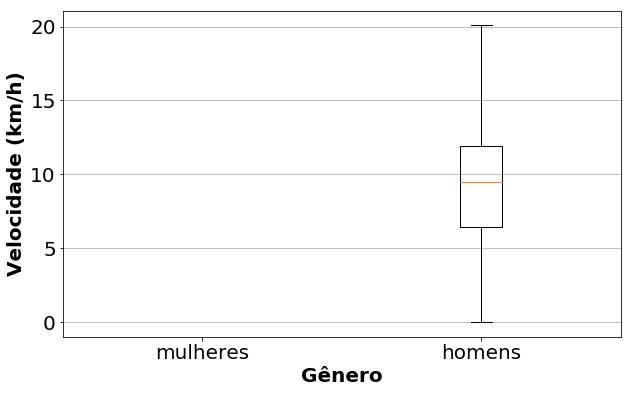

In [12]:
#boxplots
plt.figure(figsize=(10,6))
plt.xlabel('Gênero')
plt.ylabel('Velocidade (km/h)')
plt.boxplot([women_speed,men_speed],showfliers=False)
plt.xticks([1,2],['mulheres','homens'])
pos=[1,2]

### Viagens por mês e gênero - média de uso diária e desvio padrão de Janeiro de 2018 a Junho de 2019

In [13]:
trip_time_series = trips[['starttime', 'gender']]
trip_time_series = \
        trip_time_series[(trip_time_series.starttime < pd.Timestamp('2019-07-01 00:00:0000'))]
trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['starttime']), inplace=True)

### Obtendo a média diária por mês

In [14]:
trips_day_average = trip_time_series['starttime'].groupby(pd.Grouper(freq='D')).count()
trips_per_month = trips_day_average.groupby(pd.Grouper(freq='MS')).agg({'mean':'mean','std':'std'})

### Calculando o percentual de viagens de mulheres

In [15]:
#women bike usage percentage
women_trips = trip_time_series[(trip_time_series.gender == 'Fem')]
men_trips = trip_time_series[(trip_time_series.gender == 'Masc')]

women_trips_day_count = women_trips['starttime'].groupby(pd.Grouper(freq='D')).count()
men_trips_day_count = men_trips['starttime'].groupby(pd.Grouper(freq='D')).count()

women_trips_per_month = women_trips_day_count.groupby(pd.Grouper(freq='MS')).agg({'sum':'sum'})
men_trips_per_month = men_trips_day_count.groupby(pd.Grouper(freq='MS')).agg({'sum':'sum'})

women_percentage_per_month = women_trips_per_month.copy()
men_percentage_per_month = men_trips_per_month.copy()

women_percentage_per_month['percentage'] = \
    women_percentage_per_month['sum']/(women_percentage_per_month['sum']+men_percentage_per_month['sum'])*100

### Série temporal - viagens

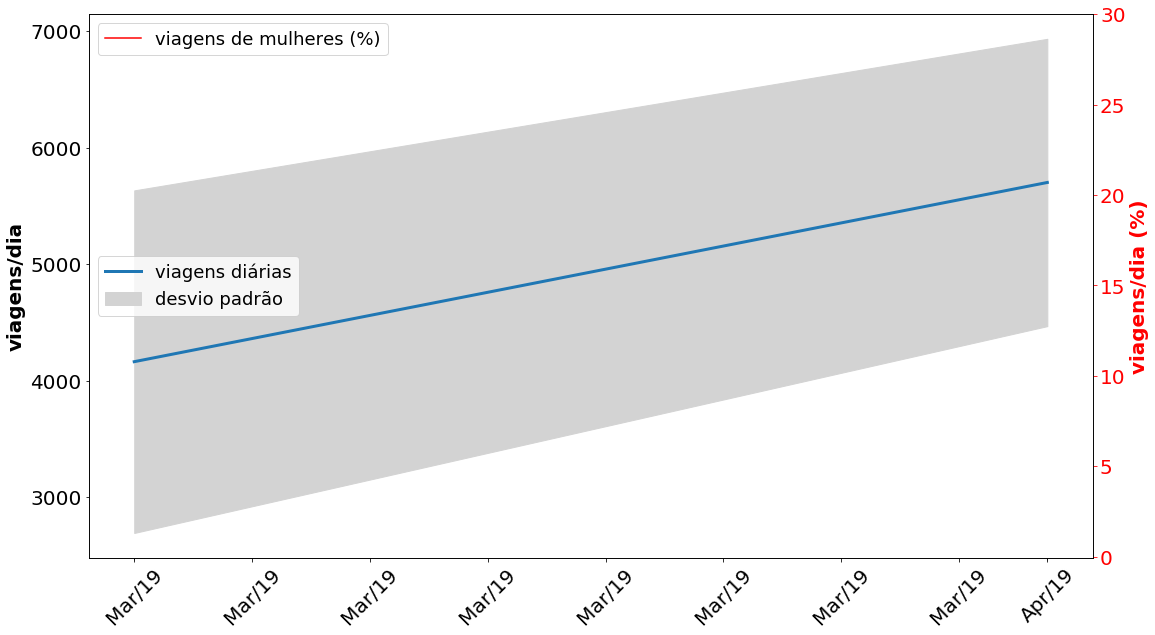

In [17]:
dateFmt = mdate.DateFormatter('%b/%y')

ax_day_avg_gender = plt.axes()
ax_day_avg_gender.set_axisbelow(True)
ax_day_avg_gender.xaxis.grid(False)
ax_day_avg_gender.yaxis.grid(False)
ax_day_avg_gender.plot(trips_per_month['mean'], label='viagens diárias', linewidth=3)
ax_day_avg_gender.figure.set_size_inches(18,10)
ax_day_avg_gender.xaxis.set_major_formatter(dateFmt)
ax_day_avg_gender.xaxis.set_minor_locator(mdate.MonthLocator())

plt.ylabel('viagens/dia')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_month.index,trips_per_month['mean']-trips_per_month['std'],
                 trips_per_month['mean']+trips_per_month['std'],color='lightgray',label='desvio padrão')
plt.legend(loc='center left')

ax_perc_women = ax_day_avg_gender.twinx()
ax_perc_women.plot(women_percentage_per_month.index,women_percentage_per_month['percentage'],label='viagens de mulheres (%)',color='red')
ax_perc_women.set_ylabel('viagens/dia (%)', color='red')
ax_perc_women.yaxis.grid(False)
ax_perc_women.xaxis.set_major_formatter(dateFmt)
ax_perc_women.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women.legend(loc='upper left')
ax_perc_women.tick_params('y',colors='red')

plt.savefig('charts/Trips-Evolution.pdf', format='pdf', dpi=200)
plt.draw()

## Ciclistas perigosos
### Viagens com velocidade média acima de 25km/h
### Há um monte deles na faixa etária de 25 e 30 anos, mas pode ocorrer em todas as idades

In [18]:
speeders = merge[merge.speed >25]
#speeders.head()

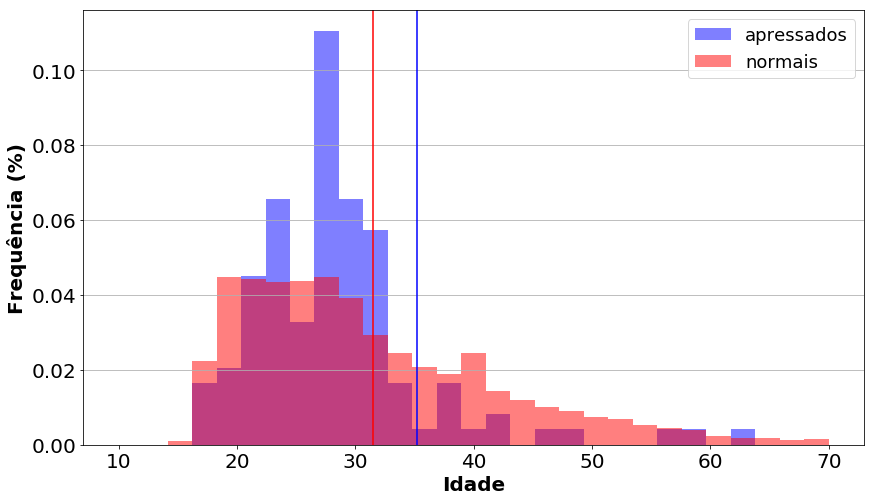

In [19]:
t = merge[~merge["birth year"].isnull()]
t["birth year"] = t["birth year"].astype(int)
t["age"] = 2018 - t["birth year"]
speeders = t[t.speed >25].age
normal  = t.age

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=5)

bins = np.linspace(10, 70, 30)
plt.hist(speeders, bins, alpha=0.5, label='apressados', density=True, color='blue')
plt.hist(normal, bins, alpha=0.5, label='normais', density=True, color='red')
#plt.xaxis.set_major_locator(loc)
plt.axvline(x=speeders.mean(),color='blue')
plt.axvline(x=normal.mean(),color='red')
plt.xlabel('Idade')
plt.ylabel('Frequência (%)')
plt.legend(loc='upper right')
plt.show()

## Padrão diário de viagens por estação e por tipo de uso (partida ou chegada)
### Selecione a estação desejada e o tipo de uso

In [24]:
def trip_daily_pattern(station, trip_point):
    print('Calculando...')
    day_counts = merge[merge[trip_point + '_station_name'] == station] \
          [['hour', 'weekend', 'per_day']].drop_duplicates() \
          .groupby(['hour', 'weekend'], as_index=False).agg({'per_day': 'count'})
    trip_counts = merge[merge[trip_point + '_station_name'] == station] \
                .groupby(['hour', 'weekend'], as_index=False).agg({'tripduration': 'count'})
    counts = day_counts.merge(trip_counts, on=['hour', 'weekend'])
    counts.rename(columns={'per_day': 'day_count', 'tripduration': 'trip_count'}, inplace=True)
    counts['daily_mean'] = counts['trip_count'] / counts['day_count']
    
    plt.figure(figsize=(20, 8))
    width=0.5
        
    for t in [False, True]:
        filtered = counts[counts['weekend'] == t]
        y = filtered['daily_mean']
        x = filtered['hour']
        if len(x) > 0:
            plt.bar(x-width/2 if t else x+width/4, y, width=width, label='fins de semana' if t else 'dias úteis')
        if len(x) >= 2:  # mininum for spline generation
            spline = CubicSpline(x, y)
            x_vals = np.linspace(x.min(), x.max(), 500, dtype=np.float64)
            y_smooth = spline(x_vals)
            plt.plot(x_vals, y_smooth)
        
    plt.xlabel('Hora')
    plt.ylabel('Média diária')
    plt.legend()
    print('Feito.')
    plt.show()
    
im = interact_manual(
    trip_daily_pattern,
    station=widgets.Dropdown(options=stations['name'].sort_values()),
    trip_point=widgets.RadioButtons(options=['start', 'end'])
)
im.widget.children[2].description = 'Mostrar gráfico' 

interactive(children=(Dropdown(description='station', options=('061-Ministerio de Economia', '081 -Balcarce', …

## Estações com maior quantidade de viagens (partida e chegada)

In [25]:
def top_stations(top,trip_point):
    print('Calculando...')
    if trip_point == 'start':
        trips_by_day = trips.groupby(['start_station_name'], as_index=False).agg({'tripduration': 'count'})
        trips_by_day.columns = ['start_station_name', 'trip count']
        trips_by_day.set_index('start_station_name',inplace=True)
    else:
        trips_by_day = trips.groupby(['end_station_name'], as_index=False).agg({'tripduration': 'count'})
        trips_by_day.columns = ['end_station_name', 'trip count']
        trips_by_day.set_index('end_station_name',inplace=True)

    trips_by_day.columns = ['# viagens']
    trips_by_day.index.name='estação'
    
    #trips_by_day.columns = ['estação','# viagens']
    #trips_by_day.index.name='posição'
    #trips_by_day.reset_index()
    
    display(trips_by_day.sort_values('# viagens', ascending=False).head(top))

im = interact_manual(
    top_stations,
    top=widgets.Dropdown(options=[('5', 5), ('10', 10), ('15', 15), ('20', 20), ('25', 25), ('30', 30)], value=10),
    trip_point=widgets.RadioButtons(options=[('origem','start'), ('destino','end')])
)
im.widget.children[0].description = '# estações' 
im.widget.children[1].description = 'Situação' 
im.widget.children[2].description = 'Mostrar lista' 

interactive(children=(Dropdown(description='top', index=1, options=(('5', 5), ('10', 10), ('15', 15), ('20', 2…